In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from platypus.core import *
from platypus.types import *
from platypus.algorithms import *
from z0_util import cal_vap_sat, cal_dens_dry, cal_dens_vap, cal_cpa, cal_dens_air, cal_Lob
import pickle
from tqdm import tqdm

In [2]:
def optimize_MO(ser_ws,ser_ustar,z_meas,h_sfc):

    def func_uz(params):
        z0=params[0]
        d=params[1]
        z = z_meas
        k = 0.4
        uz = (ser_ustar / k) * np.log((z - d) / z0)

        o1=abs(1-np.std(uz)/np.std(ser_ws))
        o2=np.mean(abs(uz-ser_ws))/(np.mean(ser_ws))
        #o2=np.mean((uz-ser_ws))/(np.mean(ser_ws))

        return [o1,o2],[uz.min(),d-z0]

    problem = Problem(2,2,2)
    problem.types[0] = Real(0, 10)
    problem.types[1] = Real(0, h_sfc)


    problem.constraints[0] = ">=0"
    problem.constraints[1] = ">=0"

    problem.function = func_uz
    random.seed(12345)
    #algorithm=CMAES(problem, epsilons=[0.005])
    algorithm=NSGAIII(problem, divisions_outer=50)
    algorithm.run(30000)
    
    return algorithm



def splitter(ser):
    ser_all={}
    ser_all['DJF']=ser[np.isin(ser.index.month,[12,1,2])]
    ser_all['MAM']=ser[np.isin(ser.index.month,[3,4,5])]
    ser_all['JJA']=ser[np.isin(ser.index.month,[6,7,8])]
    ser_all['SON']=ser[np.isin(ser.index.month,[9,10,11])]
    return ser_all


def splitter_LAI(ser,name,years,all_periods):
    
    
    
    ser_all={}
    ser_all['off']=pd.Series()
    ser_all['on']=pd.Series()
    ser_all['trans']=pd.Series()
    
    for year in years:
        
        [t1,t2,t3,t4]=all_periods[name][year]
        DOY=[x.timetuple().tm_yday for x in ser.index]

        off=[x for x in range(1,t1+1)]+[x for x in range(t4+1,366)]
        on=[x for x in range(t2,t3+1)]
        trans=[x for x in range(t1+1,t2+1)]+[x for x in range(t3+1,t4+1)]

        ser_all['off']=ser_all['off'].append(ser[np.isin(DOY,off)])
        ser_all['on']=ser_all['on'].append(ser[np.isin(DOY,on)])
        ser_all['trans']=ser_all['trans'].append(ser[np.isin(DOY,trans)])
    
    return ser_all



def split_season(ser_ws,ser_ustar):
    
    ser_ws_all=splitter(ser_ws)
    ser_ustar_all=splitter(ser_ustar)
    
    return ser_ws_all,ser_ustar_all


def read_prepare(name_of_site,years):
    
    with open('outputs/roughness/all_periods_train.pkl','rb') as f:
        all_periods=pickle.load(f)
        
    df_attr=pd.read_csv('all_attrs.csv')

    # load dataset
    
    if name_of_site in ['CN-DNT-rice','CN-DNT-wheat']:

        df_data=pd.read_csv('data/Crop/all_date.csv',index_col=0,parse_dates=True)
        df_data=df_data[(df_data['WS']!=0)]
        bb=pd.DataFrame(~np.isin(df_data.index.date,df_data[df_data.P!=0].index.date))
        bb.index=df_data.index
        df_data=df_data[bb.values]
        
        if name_of_site=='CN-DNT-rice':
            date_0=datetime.datetime(2015,6,20)
            date_1=datetime.datetime(2015,11,7)
            z_meas=df_attr[df_attr.site=='cropr'].meas.values[0]
            h_sfc=df_zmeas=df_attr[df_attr.site=='cropr'].height.values[0]
        else:
            date_0=datetime.datetime(2015,12,10)
            date_1=datetime.datetime(2016,5,25)
            z_meas=df_attr[df_attr.site=='cropw'].meas.values[0]
            h_sfc=df_zmeas=df_attr[df_attr.site=='cropw'].height.values[0]

        df_years=df_data.loc[date_0:date_1]


    elif name_of_site=='PH-IRI':
        df_data=pd.read_csv('data/Crop/IRI/all_data.csv',index_col=0,parse_dates=True)
        df_data=df_data.rename(columns={'Ta':'TA','USt':'USTAR','Rh':'RH'})
        df_data['PA']=1010
        date_0=datetime.datetime(2014,6,17)
        date_1=datetime.datetime(2014,10,1)
        z_meas=df_attr[df_attr.site=='IRI'].meas.values[0]
        h_sfc=df_zmeas=df_attr[df_attr.site=='IRI'].height.values[0]
        df_years=df_data.loc[date_0:date_1]
        
    else:
        z_meas=df_attr[df_attr.site==name_of_site].meas.values[0]
        h_sfc=df_zmeas=df_attr[df_attr.site==name_of_site].height.values[0]
        folder='data/data_csv_zip_clean_roughness/'
        site_file = folder+'/'+name_of_site + '_clean.csv.gz'
        df_data = pd.read_csv(site_file, index_col='time', parse_dates=['time'])
        # Rain
        bb=pd.DataFrame(~np.isin(df_data.index.date,df_data[df_data.P!=0].index.date))
        bb.index=df_data.index
        df_data=df_data[bb.values]
        
        if name_of_site=='US-Blk':
            df_data=df_data[df_data.USTAR>=0.25]
        else:
            df_data=df_data[df_data.USTAR!=0]
            
        df_data=df_data[(df_data['WS']!=0)]

        df_years=df_data.loc[f'{years[0]}']
        for i in years[1:]:
            df_years=df_years.append(df_data.loc[f'{i}'])
        
    # select valid values
    if name_of_site not in ['CN-DNT-rice','CN-DNT-wheat','PH-IRI']:
        df_val = df_years.loc[:, ['H', 'USTAR', 'TA', 'RH', 'PA', 'WS','WD']].dropna()
    else:
        df_val = df_years.loc[:, ['H', 'USTAR', 'TA', 'RH', 'PA', 'WS']].dropna()

    # calculate Obukhov length
    ser_Lob = df_val.apply(
        lambda ser: cal_Lob(ser.H, ser.USTAR, ser.TA, ser.RH, ser.PA * 10), axis=1)

    # zero-plane displacement: estimated using rule f thumb `d=0.7*h_sfc`

    z_d = 0.7 * h_sfc

    if z_d >= z_meas:
        print(
            'vegetation height is greater than measuring height. Please fix this before continuing'
        )

    # calculate stability scale
    ser_zL = (z_meas - z_d) / ser_Lob
    
    # determine periods under quasi-neutral conditions
    limit_neutral = 0.01
    ind_neutral = ser_zL.between(-limit_neutral, limit_neutral)

    ind_neutral=ind_neutral[ind_neutral==True]

    if name_of_site not in ['CN-DNT-rice','CN-DNT-wheat','PH-IRI']:
        df_sel = df_val.loc[ind_neutral.index, ['WS', 'USTAR','WD']].dropna()
        ser_ustar = df_sel.USTAR
        ser_ws = df_sel.WS
        ser_wd=df_sel.WD
    else:
        df_sel = df_val.loc[ind_neutral.index, ['WS', 'USTAR']].dropna()
        ser_ustar = df_sel.USTAR
        ser_ws = df_sel.WS
    
    
    
    
    if name_of_site not in ['CN-DNT-rice','CN-DNT-wheat','PH-IRI']:
        
        ser_ws_all,ser_ustar_all=split_season(ser_ws,ser_ustar)
        
        ser_ws_all=splitter_LAI(ser_ws,name_of_site,years,all_periods)
        ser_ustar_all=splitter_LAI(ser_ustar,name_of_site,years,all_periods)
        ser_wd_all=splitter_LAI(ser_wd,name_of_site,years,all_periods)
        
        
        
        all_wd={}
        for LAI_state in ['off','on','trans']:
            all_wd[LAI_state]={}
            wd_lai=ser_wd_all[LAI_state]
            for i in range(1,37):
                temp=wd_lai[(wd_lai<=i*10)&(wd_lai>(i-1)*10)]
                if len(temp)>=20:
                    all_wd[LAI_state][i*10]=temp
        
        
        algorithm_all={}
        
#         for season in ['DJF','MAM','JJA','SON']:
#             print('. . . '+season)
#             ser_ws_i=ser_ws_all[season]
#             ser_ustar_i=ser_ustar_all[season]
#             algorithm_all[season]=optimize_MO(ser_ws_i,ser_ustar_i,z_meas,h_sfc)
            
        for LAI_state in ['off','on','trans']:
        #for LAI_state in ['on']:
            
            print('. . . '+LAI_state)
            #print(f'. . . Number of wd: {len(all_wd[LAI_state].keys())}')
            
            if name_of_site in ['CA-Qcu']:
                algorithm_all[LAI_state]={}
                for wd in tqdm(all_wd[LAI_state].keys()):
                    #print(f'. . . wd = {wd}')
                    idx=all_wd[LAI_state][wd].index

                    ser_ws_i=ser_ws_all[LAI_state].loc[idx]
                    ser_ustar_i=ser_ustar_all[LAI_state].loc[idx]
                    algorithm_all[LAI_state][wd]=optimize_MO(ser_ws_i,ser_ustar_i,z_meas,h_sfc)
            else:
                    if name_of_site=='US-AR1': # Excluding potential different heights with no information
                        
                        
                        ser_ws_all[LAI_state]=ser_ws_all[LAI_state][~((ser_ws_all[LAI_state].index>'2010 05')&(ser_ws_all[LAI_state].index<'2010 12'))]
                        ser_ustar_all[LAI_state]=ser_ustar_all[LAI_state][~((ser_ustar_all[LAI_state].index>'2010 05')&(ser_ustar_all[LAI_state].index<'2010 12'))]
                        ser_ws_i=ser_ws_all[LAI_state]
                        ser_ustar_i=ser_ustar_all[LAI_state]
                        
                        algorithm_all[LAI_state]=optimize_MO(ser_ws_i,ser_ustar_i,z_meas,h_sfc)  


                    elif name_of_site=='US-KUT': # Excluding potential different heights with no information
                        
                        
                        ser_ws_all[LAI_state]=ser_ws_all[LAI_state][~((ser_ws_all[LAI_state].index>'2007 11 10')&(ser_ws_all[LAI_state].index<'2007 12 1'))]
                        ser_ustar_all[LAI_state]=ser_ustar_all[LAI_state][~((ser_ustar_all[LAI_state].index>'2007 11 10')&(ser_ustar_all[LAI_state].index<'2007 12 1'))]
                        ser_ws_i=ser_ws_all[LAI_state]
                        ser_ustar_i=ser_ustar_all[LAI_state]
                        
                        algorithm_all[LAI_state]=optimize_MO(ser_ws_i,ser_ustar_i,z_meas,h_sfc) 
                    else:
                        ser_ws_i=ser_ws_all[LAI_state]
                        ser_ustar_i=ser_ustar_all[LAI_state]
                        algorithm_all[LAI_state]=optimize_MO(ser_ws_i,ser_ustar_i,z_meas,h_sfc)               

    else:
        
        if name_of_site in ['CN-DNT-rice','CN-DNT-wheat']:
            algorithm_all={}
            all_wd={}
            ser_ws_all={}
            ser_ustar_all={}
            
            for crop_state in ['veg','rep','rip']: 
                
                if crop_state=='veg':
                    
                    if name_of_site=='CN-DNT-rice':
                        ser_ws_all[crop_state]=ser_ws.loc['2015 06 20':'2015 08 09']
                        ser_ustar_all[crop_state]=ser_ustar.loc['2015 06 20':'2015 08 09']
                    elif name_of_site=='CN-DNT-wheat':
                        ser_ws_all[crop_state]=ser_ws.loc['2015 12 10':'2016 02 29']
                        ser_ustar_all[crop_state]=ser_ustar.loc['2015 12 10':'2016 02 29']
                        
                elif crop_state=='rep':
                    
                    if name_of_site=='CN-DNT-rice':
                        ser_ws_all[crop_state]=ser_ws.loc['2015 08 10':'2015 10 01']
                        ser_ustar_all[crop_state]=ser_ustar.loc['2015 08 10':'2015 10 01']
                    elif name_of_site=='CN-DNT-wheat':
                        ser_ws_all[crop_state]=ser_ws.loc['2016 03 01':'2016 04 16']
                        ser_ustar_all[crop_state]=ser_ustar.loc['2016 03 01':'2016 04 16']
                        
                elif crop_state=='rip':
                    if name_of_site=='CN-DNT-rice':
                        ser_ws_all[crop_state]=ser_ws.loc['2015 10 02':'2015 11 07']
                        ser_ustar_all[crop_state]=ser_ustar.loc['2015 10 02':'2015 11 07']
                    elif name_of_site=='CN-DNT-wheat':
                        ser_ws_all[crop_state]=ser_ws.loc['2016 04 17':'2016 05 25']
                        ser_ustar_all[crop_state]=ser_ustar.loc['2016 04 17':'2016 05 25']
                        
            if name_of_site=='CN-DNT-rice':            
                for crop_state,h_sfc in zip(['veg','rep','rip'],[0.38,0.63,0.93]):
                    print('. . . '+crop_state)
                    ser_ws_i=ser_ws_all[crop_state]
                    ser_ustar_i=ser_ustar_all[crop_state]
                    algorithm_all[crop_state]=optimize_MO(ser_ws_i,ser_ustar_i,z_meas,h_sfc)
            elif name_of_site=='CN-DNT-wheat':
                for crop_state,h_sfc in zip(['veg','rep','rip'],[0.15,0.60,0.87]):
                    print('. . . '+crop_state)
                    ser_ws_i=ser_ws_all[crop_state]
                    ser_ustar_i=ser_ustar_all[crop_state]
                    algorithm_all[crop_state]=optimize_MO(ser_ws_i,ser_ustar_i,z_meas,h_sfc)            
        else:
            all_wd={}
            ser_ustar_all=ser_ustar
            ser_ws_all=ser_ws
            algorithm_all=optimize_MO(ser_ws_all,ser_ustar_all,z_meas,h_sfc)
    
    

    return algorithm_all,z_meas,ser_ustar_all,ser_ws_all,h_sfc,all_wd

        

In [208]:
names=['US-MMS','US-UMB','US-Oho','CA-Obs','CA-Qcu',
       'US-Blk','US-AR1','US-KUT','CN-DNT-rice','CN-DNT-wheat','PH-IRI']


# years_all={names[0]:[2010,2012,2016],
#        names[1]:[2010,2014],   # No 2016?
#        names[2]:[2011,2012,2013],
#        names[3]:[2003,2005,2006],
#        names[4]:[2005,2008,2009],
#        names[5]:[2004,2006,2008],
#        #names[6]:[2010,2011],
#        names[6]:[2010,2011],
#        names[7]:[2006,2007],
#        names[8]:[2016],
#        names[9]:[2014],
#        names[10]:[2013]
#       }



years_all={names[0]:[2017],
       names[1]:[2008],   # No 2016?
       names[2]:[2010],
       names[3]:[2008],
       names[4]:[2010],
       names[5]:[2005],
       names[6]:[2012],
       names[7]:[2007],
       names[8]:[2015],
       names[9]:[2016],
       names[10]:[2014]
      }



#res={}
for name_of_site in names[10:11]:
    res[name_of_site]={}
    years=years_all[name_of_site]
    print(name_of_site)
    
    algorithm,z_meas,ser_ustar,ser_ws,h_sfc,all_wd=read_prepare(name_of_site,years)
    
    
    if name_of_site not in ['CN-DNT-rice','CN-DNT-wheat','PH-IRI']:
        
#         for season in ['DJF','MAM','JJA','SON']:
#             res[name_of_site][season]={}
#             algorithm_i=algorithm[season]
#             ser_ustar_i=ser_ustar[season]
#             ser_ws_i=ser_ws[season]

        #for LAI_state in ['on']:
        for LAI_state in ['on','off','trans']:
            res[name_of_site][LAI_state]={}
            if name_of_site in ['CA-Qcu']:
                for wd in all_wd[LAI_state].keys():
                    
                    res[name_of_site][LAI_state][wd]={}
                    idx1=all_wd[LAI_state][wd].index
                    algorithm_i=algorithm[LAI_state][wd]
                    ser_ustar_i=ser_ustar[LAI_state].loc[idx1]
                    ser_ws_i=ser_ws[LAI_state].loc[idx1]

                    a=[]
                    z0s=[]
                    ds=[]
                    os1=[]
                    os2=[]
                    for s in algorithm_i.result:
                        z0s.append(s.variables[0])
                        ds.append(s.variables[1])
                        os1.append(s.objectives[0])
                        os2.append(s.objectives[1])

                    def uz(z0,d):
                        z = z_meas
                        k = 0.4
                        uz = (ser_ustar_i / k) * np.log((z - d) / z0)
                        return uz


                    try:

                        #idx=os2.index(np.min(os2))
                        idx=os2.index(min(os2, key=lambda x:abs(x-np.mean(os2))))


                        z0=np.mean(z0s[idx])
                        d=np.mean(ds[idx])


                        res[name_of_site][LAI_state][wd]['z0s']=z0s
                        res[name_of_site][LAI_state][wd]['ds']=ds
                        res[name_of_site][LAI_state][wd]['z0']=z0
                        res[name_of_site][LAI_state][wd]['d']=d
                        res[name_of_site][LAI_state][wd]['ws_obs']=ser_ws_i
                        res[name_of_site][LAI_state][wd]['ustar']=ser_ustar_i
                        res[name_of_site][LAI_state][wd]['h_sfc']=h_sfc
                        res[name_of_site][LAI_state][wd]['ws_mod']=uz(z0,d)

                    except:
                        print('some exception happened for '+name_of_site+' in LAI_state: '+LAI_staten)
                        print('The reason migh be because of no data for the particular season')
                        pass
            else:
                

                algorithm_i=algorithm[LAI_state]
                ser_ustar_i=ser_ustar[LAI_state]
                ser_ws_i=ser_ws[LAI_state]

                a=[]
                z0s=[]
                ds=[]
                os1=[]
                os2=[]
                for s in algorithm_i.result:
                    z0s.append(s.variables[0])
                    ds.append(s.variables[1])
                    os1.append(s.objectives[0])
                    os2.append(s.objectives[1])

                def uz(z0,d):
                    z = z_meas
                    k = 0.4
                    uz = (ser_ustar_i / k) * np.log((z - d) / z0)
                    return uz


                try:

                    #idx=os2.index(np.min(os2))
                    idx=os2.index(min(os2, key=lambda x:abs(x-np.mean(os2))))


                    z0=np.mean(z0s[idx])
                    d=np.mean(ds[idx])


                    res[name_of_site][LAI_state]['z0s']=z0s
                    res[name_of_site][LAI_state]['ds']=ds
                    res[name_of_site][LAI_state]['z0']=z0
                    res[name_of_site][LAI_state]['d']=d
                    res[name_of_site][LAI_state]['ws_obs']=ser_ws_i
                    res[name_of_site][LAI_state]['ustar']=ser_ustar_i
                    res[name_of_site][LAI_state]['h_sfc']=h_sfc
                    res[name_of_site][LAI_state]['ws_mod']=uz(z0,d)

                except:
                    print('some exception happened for '+name_of_site+' in LAI_state: '+LAI_staten)
                    print('The reason migh be because of no data for the particular season')
                    pass
        
    else:    

        if name_of_site in ['CN-DNT-rice','CN-DNT-wheat']:
 
            for crop_state in ['veg','rep','rip']:
                res[name_of_site][crop_state]={}
                algorithm_i=algorithm[crop_state]
                ser_ustar_i=ser_ustar[crop_state]
                ser_ws_i=ser_ws[crop_state]
                
                a=[]
                z0s=[]
                ds=[]
                os1=[]
                os2=[]
                for s in algorithm_i.result:
                    z0s.append(s.variables[0])
                    ds.append(s.variables[1])
                    os1.append(s.objectives[0])
                    os2.append(s.objectives[1])

                def uz(z0,d):
                    z = z_meas
                    k = 0.4
                    uz = (ser_ustar_i / k) * np.log((z - d) / z0)
                    return uz



                idx=os2.index(np.min(os2))
                z0=np.mean(z0s[idx])
                d=np.mean(ds[idx])

                res[name_of_site][crop_state]['z0s']=z0s
                res[name_of_site][crop_state]['ds']=ds

                res[name_of_site][crop_state]['z0']=z0
                res[name_of_site][crop_state]['d']=d
                res[name_of_site][crop_state]['ws_obs']=ser_ws_i
                res[name_of_site][crop_state]['h_sfc']=h_sfc
                res[name_of_site][crop_state]['ws_mod']=uz(z0,d)

            
            
        else:
            a=[]
            z0s=[]
            ds=[]
            os1=[]
            os2=[]
            for s in algorithm.result:
                z0s.append(s.variables[0])
                ds.append(s.variables[1])
                os1.append(s.objectives[0])
                os2.append(s.objectives[1])

            def uz(z0,d):
                z = z_meas
                k = 0.4
                uz = (ser_ustar / k) * np.log((z - d) / z0)
                return uz



            idx=os2.index(np.min(os2))
            z0=np.mean(z0s[idx])
            d=np.mean(ds[idx])

            res[name_of_site]['z0s']=z0s
            res[name_of_site]['ds']=ds

            res[name_of_site]['z0']=z0
            res[name_of_site]['d']=d
            res[name_of_site]['ws_obs']=ser_ws
            res[name_of_site]['h_sfc']=h_sfc
            res[name_of_site]['ws_mod']=uz(z0,d)

PH-IRI


In [ ]:
colors=['b','g','k'] 
fig,axes=plt.subplots(2,1,figsize=(7,5))
plt.subplots_adjust(hspace=0.004)
for LAI_state,color in zip(['off', 'on','trans'],colors):
    name_si='CA-Qcu'
    for wd in res[name_si][LAI_state].keys():
        ax=axes[0]
        hsfc=np.mean(res[name_si][LAI_state][wd]['h_sfc'])
        ax.scatter(wd,np.mean(res[name_si][LAI_state][wd]['z0s']/hsfc),color=color,label=None)
        ax.set_ylabel('$z_0/h_v$')
        ax.set_xticklabels([''])
        ax.set_title(name_si)
        ax=axes[1]

        ax.scatter(wd,np.mean(res[name_si][LAI_state][wd]['ds']/hsfc),color=color,label=None)
        ax.set_ylabel('$z_d/h_v$')
        ax.set_xlabel('WD')
        
ax=axes[0]      
ax.scatter([],[],color='b',label='off')
ax.scatter([],[],color='g',label='on')
ax.scatter([],[],color='k',label='transition')
ax.legend()

plt.savefig(f'{name_si}-z0d-vs-WD',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

In [225]:
for crop_state,h_sfc in zip(['veg','rep','rip'],[0.38,0.63,0.93]):
    res['CN-DNT-rice'][crop_state]['h_sfc']=h_sfc
    
    
    
for crop_state,h_sfc in zip(['veg','rep','rip'],[0.15,0.60,0.87]):
    res['CN-DNT-wheat'][crop_state]['h_sfc']=h_sfc
    
    
a=res['CN-DNT-wheat']['rep']['ws_mod']-res['CN-DNT-wheat']['rep']['ws_obs']
res['CN-DNT-wheat']['rep']['ws_mod']=res['CN-DNT-wheat']['rep']['ws_mod'].loc[a[a<2].index]
res['CN-DNT-wheat']['rep']['ws_obs']=res['CN-DNT-wheat']['rep']['ws_obs'].loc[a[a<2].index]

In [227]:
with open('outputs/roughness/all_roughness_train.pkl','wb') as f:
    pickle.dump(res, f)

In [3]:
with open('outputs/roughness/all_roughness_train.pkl','rb') as f:
    res=pickle.load(f)

# Plotting

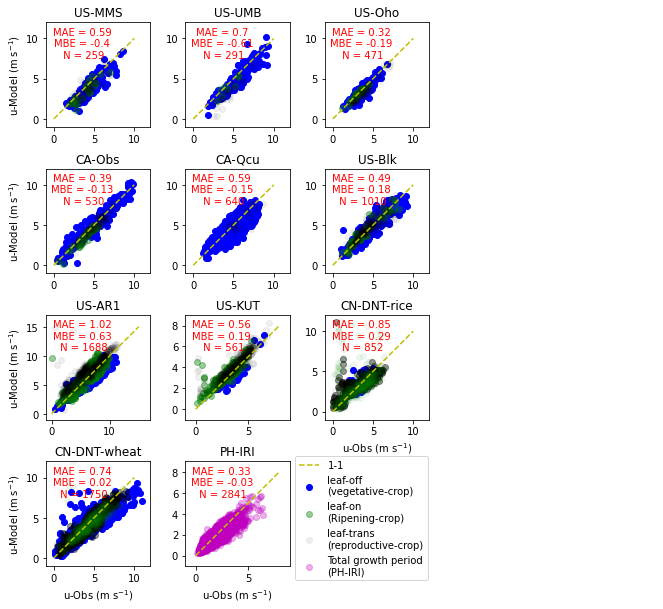

In [7]:
names=['US-MMS','US-UMB','US-Oho','CA-Obs','CA-Qcu',
       'US-Blk','US-AR1','US-KUT','CN-DNT-rice','CN-DNT-wheat','PH-IRI']


fig,axs=plt.subplots(4,3,figsize=(15,10))
plt.subplots_adjust(hspace=.4,wspace=-.75)
# ratio_z0=[]
# ratio_d=[]
# colors=['b','g','r','y']
colors=['b','g','k']
alphas=[1,0.4,0.06]
#colors=['b']
for i,name in enumerate(names[:]):
    #print(name)
    MAE_all=[]
    MBE_all=[]
    number_all=0
    ax=axs[int(np.floor((i)/3))][int(i-3*(np.floor((i)/3)))]
    if name not in ['CN-DNT-rice','CN-DNT-wheat','PH-IRI']: 
    
#         for LAI_state,color in zip(['off','trans','on'],colors):
        for LAI_state,color,alpha in zip(['off','on','trans'],colors,alphas):

            try:
                if name in ['CA-Qcu']:
                    for wd in res[name][LAI_state].keys():
                        z0=res[name][LAI_state][wd]['z0']
                        d=res[name][LAI_state][wd]['d']
                        h_sfc=res[name][LAI_state][wd]['h_sfc']
                        ser_ws=res[name][LAI_state][wd]['ws_obs']
                        ws_mod=res[name][LAI_state][wd]['ws_mod']
                        MAE_all.append(np.mean(abs(ws_mod-ser_ws)))
                        MBE_all.append(np.mean(ws_mod-ser_ws))
                        number_all+=len(ws_mod)
                #         ratio_z0.append(z0/h_sfc)
                #         ratio_d.append(d/h_sfc)
                        if name=='CA-Qcu-1':
                            y='2009'
                            if color =='k':
                                ax.scatter(ser_ws.loc[y],ws_mod.loc[y],color=color,alpha=alpha)
                            else:
                                temp_obs=ser_ws.loc[y]
                                temp_mod=ws_mod.loc[y]
                                ax.scatter(ser_ws.loc[y],ws_mod.loc[y],color=color,alpha=alpha)
                        else:
                            if color =='k':
                                ax.scatter(ser_ws,ws_mod,color=color,alpha=alpha)
                            else:
                                ax.scatter(ser_ws,ws_mod,color=color,alpha=alpha)
                else:
                    z0=res[name][LAI_state]['z0']
                    d=res[name][LAI_state]['d']
                    h_sfc=res[name][LAI_state]['h_sfc']
                    ser_ws=res[name][LAI_state]['ws_obs']
                    ws_mod=res[name][LAI_state]['ws_mod']
                    MAE_all.append(np.mean(abs(ws_mod-ser_ws)))
                    MBE_all.append(np.mean(ws_mod-ser_ws))
                    number_all+=len(ws_mod)
            #         ratio_z0.append(z0/h_sfc)
            #         ratio_d.append(d/h_sfc)
                    if name=='CA-Qcu-1':
                        y='2009'
                        if color =='k':
                            ax.scatter(ser_ws.loc[y],ws_mod.loc[y],color=color,alpha=alpha)
                        else:
                            temp_obs=ser_ws.loc[y]
                            temp_mod=ws_mod.loc[y]
                            ax.scatter(ser_ws.loc[y],ws_mod.loc[y],color=color,alpha=alpha)
                    else:
                        if color =='k':
                            ax.scatter(ser_ws,ws_mod,color=color,alpha=alpha)
                        else:
                            ax.scatter(ser_ws,ws_mod,color=color,alpha=alpha)
            except:
                pass
    else:
        
        
        if name in ['CN-DNT-rice','CN-DNT-wheat']:
            
            for crop_state,color,alpha in zip(['veg','rep','rip'],['b','k','g'],[1,0.4,0.06]):
                z0=res[name][crop_state]['z0']
                d=res[name][crop_state]['d']
                h_sfc=res[name][crop_state]['h_sfc']
                ser_ws=res[name][crop_state]['ws_obs']
                ws_mod=res[name][crop_state]['ws_mod']
                MAE_all.append(np.mean(abs(ws_mod-ser_ws)))
                MBE_all.append(np.mean(ws_mod-ser_ws))
                number_all+=len(ws_mod)
                ax.scatter(ser_ws,ws_mod,color=color,alpha=alpha)            
            
            
        else:
            z0=res[name]['z0']
            d=res[name]['d']
            h_sfc=res[name]['h_sfc']
            ser_ws=res[name]['ws_obs']
            ws_mod=res[name]['ws_mod']
            MAE_all.append(np.mean(abs(ws_mod-ser_ws)))
            MBE_all.append(np.mean(ws_mod-ser_ws))
            number_all+=len(ws_mod)
    #         ratio_z0.append(z0/h_sfc)
    #         ratio_d.append(d/h_sfc)
            ax.scatter(ser_ws,ws_mod,color='m',alpha=0.3)
    
    
    
    
    text1=f'MAE = {np.round(np.mean(MAE_all),2)}\nMBE = {np.round(np.mean(MBE_all),2)}\n N = {number_all}'
    ax.text(0.35, 0.8,text1, ha='center', va='center',color='r', transform=ax.transAxes,
            bbox=dict(facecolor='none', edgecolor='none',alpha=0.1))
    
    ax.set_ylim([-1,12])
    ax.set_xlim([-1,12])
    
    if name =='US-AR1':
        ax.plot([0,15],[0,15],c='y',linestyle='--')
        ax.set_ylim([-1,17])
        ax.set_xlim([-1,17])
    elif name in ['PH-IRI','US-KUT']:
        ax.plot([0,8],[0,8],c='y',linestyle='--')
        ax.set_ylim([-1,9])
        ax.set_xlim([-1,9])
    else:
        ax.plot([0,10],[0,10],c='y',linestyle='--')
        
    
    if name in ['CN-DNT-wheat','PH-IRI','CN-DNT-rice']:
        ax.set_xlabel('u-Obs (m s$^{-1}$)' )
    if name in ['US-MMS','CA-Obs','US-AR1','CN-DNT-wheat',]:
        ax.set_ylabel('u-Model (m s$^{-1}$)')
    
    ax.set_title(name+'  (z$_{0m}$='+str(np.round(z0,2))+', z$_d$='+str(np.round(d,2))+', h$_v$='+str(h_sfc)+')')
    ax.set_title(name)
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1 - x0) / abs(y1 - y0))
    
    if name=='US-MMS':
        ax.scatter([],[],color='m',alpha=0.3)
        ax.legend(['1-1','leaf-off\n(vegetative-crop)',
                   'leaf-on\n(Ripening-crop)',
                   'leaf-trans\n(reproductive-crop)',
                   'Total growth period\n(PH-IRI)'],bbox_to_anchor=(3.7, -3.1),fontsize=10)
    
axs[3][2].axis('off')
plt.savefig('WS_obs_mod-LAI-off.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

In [9]:
pd.DataFrame.from_dict(all_data)

,US-MMS,US-UMB,US-Oho,CA-Obs,CA-Qcu,US-Blk,US-AR1,US-KUT,CN-DNT-rice,CN-DNT-wheat,PH-IRI
off,"{'$z_0$': 3.56, '$z_d$': 19.19, 'MAE': 0.58, '...","{'$z_0$': 3.24, '$z_d$': 7.22, 'MAE': 0.58, 'M...","{'$z_0$': 5.16, '$z_d$': 8.18, 'MAE': 0.33, 'M...","{'$z_0$': 1.24, '$z_d$': 3.73, 'MAE': 0.41, 'M...","{'$z_0$': 0.32, '$z_d$': 5.14, 'MAE': 0.58, 'M...","{'$z_0$': 2.95, '$z_d$': 6.46, 'MAE': 0.45, 'M...","{'$z_0$': 0.03, '$z_d$': 0.83, 'MAE': 0.82, 'M...","{'$z_0$': 0.0, '$z_d$': 0.06, 'MAE': 0.59, 'MB...",NaN,NaN,NaN
on,"{'$z_0$': 3.21, '$z_d$': 10.9, 'MAE': 0.54, 'M...","{'$z_0$': 3.69, '$z_d$': 9.06, 'MAE': 0.5, 'MB...","{'$z_0$': 5.42, '$z_d$': 7.99, 'MAE': 0.16, 'M...","{'$z_0$': 1.77, '$z_d$': 3.76, 'MAE': 0.39, 'M...","{'$z_0$': nan, '$z_d$': nan, 'MAE': nan, 'MBE'...","{'$z_0$': 2.38, '$z_d$': 6.63, 'MAE': 0.44, 'M...","{'$z_0$': 0.03, '$z_d$': 0.83, 'MAE': 0.91, 'M...","{'$z_0$': 0.02, '$z_d$': 0.06, 'MAE': 0.5, 'MB...",NaN,NaN,NaN
trans,"{'$z_0$': 3.95, '$z_d$': 8.2, 'MAE': 0.66, 'MB...","{'$z_0$': 4.28, '$z_d$': 15.36, 'MAE': 1.03, '...","{'$z_0$': 5.54, '$z_d$': 9.54, 'MAE': 0.46, 'M...","{'$z_0$': 1.55, '$z_d$': 2.22, 'MAE': 0.39, 'M...","{'$z_0$': 0.31, '$z_d$': 2.47, 'MAE': 0.72, 'M...","{'$z_0$': 2.62, '$z_d$': 6.56, 'MAE': 0.58, 'M...","{'$z_0$': 0.01, '$z_d$': 0.9, 'MAE': 1.32, 'MB...","{'$z_0$': 0.01, '$z_d$': 0.06, 'MAE': 0.57, 'M...",NaN,NaN,NaN
veg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'$z_0$': 0.24, '$z_d$': 0.31, 'MAE': 0.42, 'M...","{'$z_0$': 0.12, '$z_d$': 0.14, 'MAE': 0.91, 'M...",NaN
rip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'$z_0$': 0.55, '$z_d$': 0.83, 'MAE': 1.3, 'MB...","{'$z_0$': 0.38, '$z_d$': 0.65, 'MAE': 0.85, 'M...",NaN
rep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'$z_0$': 0.19, '$z_d$': 0.39, 'MAE': 0.84, 'M...","{'$z_0$': 0.2, '$z_d$': 0.45, 'MAE': 0.48, 'MB...",NaN
Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'$z_0$': 0.05, '$z_d$': 0.89, 'MAE': 0.33, 'M..."


In [10]:
all_data

{'US-MMS': {'off': {'$z_0$': 3.56,
   '$z_d$': 19.19,
   'MAE': 0.58,
   'MBE': -0.38,
   'N': 145,
   'h_sfc': 25.0},
  'on': {'$z_0$': 3.21,
   '$z_d$': 10.9,
   'MAE': 0.54,
   'MBE': -0.41,
   'N': 25,
   'h_sfc': 25.0},
  'trans': {'$z_0$': 3.95,
   '$z_d$': 8.2,
   'MAE': 0.66,
   'MBE': -0.4,
   'N': 89,
   'h_sfc': 25.0}},
 'US-UMB': {'off': {'$z_0$': 3.24,
   '$z_d$': 7.22,
   'MAE': 0.58,
   'MBE': -0.44,
   'N': 235,
   'h_sfc': 20.0},
  'on': {'$z_0$': 3.69,
   '$z_d$': 9.06,
   'MAE': 0.5,
   'MBE': -0.36,
   'N': 8,
   'h_sfc': 20.0},
  'trans': {'$z_0$': 4.28,
   '$z_d$': 15.36,
   'MAE': 1.03,
   'MBE': -1.03,
   'N': 48,
   'h_sfc': 20.0}},
 'US-Oho': {'off': {'$z_0$': 5.16,
   '$z_d$': 8.18,
   'MAE': 0.33,
   'MBE': -0.19,
   'N': 354,
   'h_sfc': 24.0},
  'on': {'$z_0$': 5.42,
   '$z_d$': 7.99,
   'MAE': 0.16,
   'MBE': 0.0,
   'N': 27,
   'h_sfc': 24.0},
  'trans': {'$z_0$': 5.54,
   '$z_d$': 9.54,
   'MAE': 0.46,
   'MBE': -0.38,
   'N': 90,
   'h_sfc': 24.0}},
 '

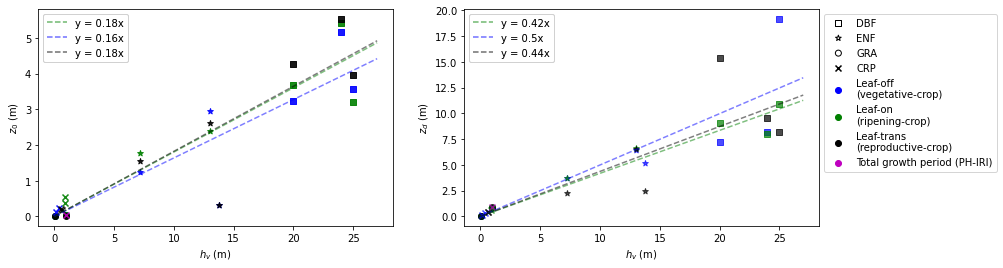

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from sklearn.linear_model import LinearRegression
names=['US-MMS','US-UMB','US-Oho','CA-Obs','CA-Qcu',
       'US-Blk','US-AR1','US-KUT','CN-DNT-rice','CN-DNT-wheat','PH-IRI']


shapes_all={names[0]:'s',
       names[1]:'s',
       names[2]:'s',
       names[3]:'*',
       names[4]:'*',
       names[5]:'*',
       names[6]:'o',
       names[7]:'o',
       names[8]:'x',
       names[9]:'x',
       names[10]:'x'
      }

colors={
    
    'on':'g',
    'off':'b',
    'trans':'k',
    'veg':'b',
    'rip':'g',
    'rep':'k',
    'Growth':'m'
    
    
}

fig,axs=plt.subplots(1,2,figsize=(14,4))

X_states_on=[]
X_states_off=[]
X_states_trans=[]
Y_states_on=[]
Y_states_off=[]
Y_states_trans=[]


X1_states_on=[]
X1_states_off=[]
X1_states_trans=[]
Y1_states_on=[]
Y1_states_off=[]
Y1_states_trans=[]

for site in all_data.keys():
    
    ax=axs[0]

    
    for state in all_data[site].keys():
        
        if state in ['on','rip'] and ~np.isnan(all_data[site][state]['$z_0$']):
            X_states_on.append(all_data[site][state]['h_sfc'])
            Y_states_on.append(all_data[site][state]['$z_0$'])
        if state in ['off','veg']:
            X_states_off.append(all_data[site][state]['h_sfc'])
            Y_states_off.append(all_data[site][state]['$z_0$'])
        if state in ['trans','rep']:
            X_states_trans.append(all_data[site][state]['h_sfc'])
            Y_states_trans.append(all_data[site][state]['$z_0$'])
        
        ax.scatter(all_data[site][state]['h_sfc'],
                    all_data[site][state]['$z_0$'],
                    marker=shapes_all[site],
                   color=colors[state],alpha=0.9,label=None)

        

    
    
    ax=axs[1]
    for state in all_data[site].keys():
        
        if state in ['on','rip'] and ~np.isnan(all_data[site][state]['$z_d$']):
            X1_states_on.append(all_data[site][state]['h_sfc'])
            Y1_states_on.append(all_data[site][state]['$z_d$'])
        if state in ['off','veg']:
            X1_states_off.append(all_data[site][state]['h_sfc'])
            Y1_states_off.append(all_data[site][state]['$z_d$'])
        if state in ['trans','rep']:
            X1_states_trans.append(all_data[site][state]['h_sfc'])
            Y1_states_trans.append(all_data[site][state]['$z_d$'])
            
        ax.scatter(all_data[site][state]['h_sfc'],
                    all_data[site][state]['$z_d$'],
                    marker=shapes_all[site],
                   color=colors[state],alpha=0.7,label=None)
    


    
    
    

ax.scatter([],[],marker='s',color='k',facecolors='none',label='DBF')
ax.scatter([],[],marker='*',color='k',facecolors='none',label='ENF')
ax.scatter([],[],marker='o',color='k',facecolors='none',label='GRA')
ax.scatter([],[],marker='x',color='k',label='CRP')

ax.scatter([],[],marker='o',color='b',label='Leaf-off\n(vegetative-crop)')
ax.scatter([],[],marker='o',color='g',label='Leaf-on\n(ripening-crop)')
ax.scatter([],[],marker='o',color='k',label='Leaf-trans\n(reproductive-crop)')
ax.scatter([],[],marker='o',color='m',label='Total growth period (PH-IRI)')
l1=ax.legend(bbox_to_anchor=(1, 1),fontsize=10)

ax=axs[0]
ax.set_ylabel('$z_0$ (m)')
ax.set_xlabel('$h_v$ (m)')

sol_on=LinearRegression(fit_intercept=False).fit(np.array(X_states_on).reshape(-1,1),Y_states_on).coef_
ax.plot([0,27],[0*sol_on[0],27*sol_on[0]],color='g',linestyle='--',alpha=0.5)

sol_off=LinearRegression(fit_intercept=False).fit(np.array(X_states_off).reshape(-1,1),Y_states_off).coef_
ax.plot([0,27],[0*sol_off[0],27*sol_off[0]],color='b',linestyle='--',alpha=0.5)

sol_trans=LinearRegression(fit_intercept=False).fit(np.array(X_states_trans).reshape(-1,1),Y_states_trans).coef_
ax.plot([0,27],[0*sol_trans[0],27*sol_trans[0]],color='k',linestyle='--',alpha=0.5)


l2=ax.legend([f'y = {np.round(sol_on[0],2)}x',
              f'y = {np.round(sol_off[0],2)}x',
              f'y = {np.round(sol_trans[0],2)}x'])
ax.add_artist(l2)

ax=axs[1]
ax.set_ylabel('$z_d$ (m)')
ax.set_xlabel('$h_v$ (m)')

sol_on=LinearRegression(fit_intercept=False).fit(np.array(X1_states_on).reshape(-1,1),Y1_states_on).coef_
ax.plot([0,27],[0*sol_on[0],27*sol_on[0]],color='g',linestyle='--',alpha=0.5)

sol_off=LinearRegression(fit_intercept=False).fit(np.array(X1_states_off).reshape(-1,1),Y1_states_off).coef_
ax.plot([0,27],[0*sol_off[0],27*sol_off[0]],color='b',linestyle='--',alpha=0.5)

sol_trans=LinearRegression(fit_intercept=False).fit(np.array(X1_states_trans).reshape(-1,1),Y1_states_trans).coef_
ax.plot([0,27],[0*sol_trans[0],27*sol_trans[0]],color='k',linestyle='--',alpha=0.5)

l2=ax.legend([f'y = {np.round(sol_on[0],2)}x',
              f'y = {np.round(sol_off[0],2)}x',
              f'y = {np.round(sol_trans[0],2)}x'])
ax.add_artist(l1)
ax.add_artist(l2)
plt.savefig('z_vs_h.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)